# Python自动化报表分析

**说明**
本脚本应当与CSMAR数据库配合，具体使用步骤：
- 下载**某一**公司的全部报表，提取资产负债表、利润表两份excel文件，置于同一文件夹中
- 在下方的脚本块`os.chdir(r'……')`的引号中写入上述excel文件的路径
- 可在`cm='#……'`中输入心仪的主题色（注：颜色不宜太亮/太浅）
- 运行全部代码

## 1.   基础配置

In [254]:
#coding=utf-8
import os
import math

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# 色彩模块
import colorsys
from PIL import Image

plt.rcParams['font.sans-serif'] = ['KaiTi']
plt.rcParams['axes.unicode_minus'] = False

def limit(max, min=0, model=10):
    # 把model缩放为(0, 10]
    model = abs(model)
    if model != 10:
        model = model / pow(10, int(math.log(model, 10)))

    unit = pow(10, int(math.log(max, 10)))  # 最大10倍数，如12亿，得到10亿；0.12，得到0.1
    unit = unit / 10 * model
    
    ul = int(max / unit) + 1

    if min != 0:
        ll = int(min / unit) - 1
    else:
        ll = 0
    '''
    while ((ul - ll) % 5 != 0) and ((ul - ll) % 6 != 0) and ((ul - ll) % 4 != 0):
        ul += 1
    '''
    if min == 0:
        return [0, ul * unit, unit]
    else:
        return [ll * unit, ul * unit, unit]
    
def ylim(ax, max, min, model=10):
    a = limit(max, min, model)
    ax.set_ylim(a[0], a[1])

def rgb2hsb(rgb):   # 转为 HSB 色值
    rgb = (int(rgb[1:3], 16), int(rgb[3:5], 16), int(rgb[5:], 16))
    hsv = colorsys.rgb_to_hsv(rgb[0] / 255, rgb[1] / 255, rgb[2] / 255)

    return hsv

def hsb2rgb(h, s, b):   # 转回 RGB 色系
    rgb = colorsys.hsv_to_rgb(h, s, b)
    rgb = '#' + hex(int(rgb[0] * 255))[2:] + hex(int(rgb[1] * 255))[2:] + hex(int(rgb[2] * 255))[2:]

    return rgb  # 一个带#号的字符串

def lightcolor(rgb):    # 生成两个浅色
    hsb = rgb2hsb(rgb)

    if hsb[1] > 0.1:
        l2s = 0.1
    else:
        l2s = 0
    l1s = (l2s + hsb[1]) / 2

    if hsb[2] <= 0.99:
        l2b = 0.99
    else:
        l2b = 1
    l1b = (hsb[2] + l2b) / 2

    l1 = hsb2rgb(hsb[0], l1s, l1b)
    l2 = hsb2rgb(hsb[0], l2s, l2b)

    return [l1, l2]

def neighborcolor(rgb): # 生成两个相邻色
    hsb = rgb2hsb(rgb)

    h2 = hsb[1] + (1/3)
    if h2 > 1:
        h2 -= 1
    
    h3 = h2 + (1/3)
    if h3 > 1:
        h3 -= 1
    
    h2 = hsb2rgb(h2, hsb[1], hsb[2])
    h3 = hsb2rgb(h3, hsb[1], hsb[2])

    return [h2, h3]

In [ ]:
# 在r后面的引号中写入报表文件所在目录
os.chdir(r'E:\18082\Documents\9 CodeProjects\03 自动财报分析')

# 写入想要的主题色
cm = '#9cc3e5'

### 配色方案

In [278]:
cm_l1 = lightcolor(cm)[0]   # 生成两个浅色
cm_l2 = lightcolor(cm)[1]

# 两个相邻色
cn1 = neighborcolor(cm)[0]
cn2 = neighborcolor(cm)[1]

gray = '#d8d8d8'
black = '#000000'

## 2.   数据整理

In [153]:
def DataClean(filename):
    df = pd.read_excel(filename, sheet_name='sheet1', header=None)
    df.loc[1, 1] = '会计期间'
    df.columns = df.values.tolist()[1]
    df = df[df['会计期间'].apply(lambda x: x[5:7] == "12")]
    #df = df.set_index('会计期间')
    df = df[df['报表类型'].isin(['A'])].fillna(value=0)
    return df


### 合并三张报表

In [154]:
BalanceSheet = DataClean('FS_Combas.xlsx')
IncomeSheet = DataClean('FS_Comins.xlsx')
CashFlowSheet = DataClean('FS_Comscfd.xlsx')

TheSheet = pd.merge(BalanceSheet, IncomeSheet, on='会计期间')
TheSheet = pd.merge(TheSheet, CashFlowSheet, on='会计期间')

x = TheSheet.loc[:, '会计期间']

e:\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
e:\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


## 3.   绘图

### 3.1.    企业经营总览

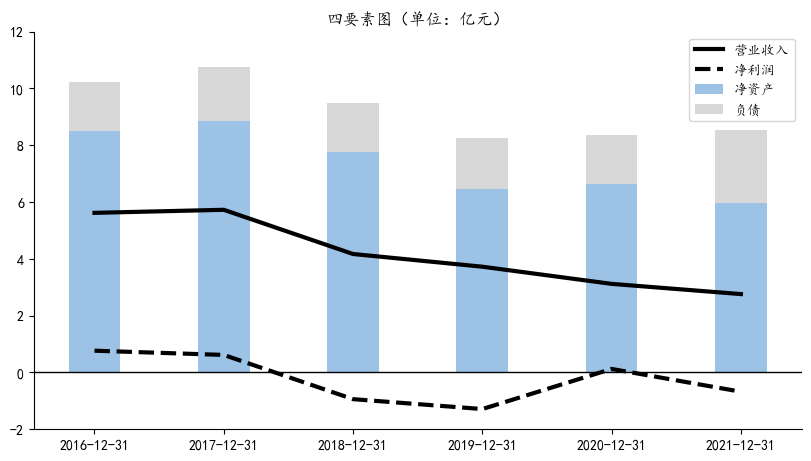

In [279]:
max_number = max(TheSheet.loc[:, '营业总收入'].max(), TheSheet.loc[:, '资产总计'].max())
min_number = min(TheSheet.loc[:, '净利润'].min(), TheSheet.loc[:, '所有者权益合计'].min(), 0)

if max_number >= 1000000000:
    a = 100000000   # 单位
    title = '（单位：亿元）'
else:
    a = 10000
    title = '（单位：万元）'

max_number = max_number / a
min_number = min_number / a

fig, ax = plt.subplots(figsize=(8, 4.5), layout='constrained')

# 三个参数，最大值，最小值，模式
# 模式默认不填，y轴以10为单位；
ylim(ax, max_number, min_number, 2)

ax.bar(x, TheSheet.loc[:, '所有者权益合计'] / a, label='净资产', width=0.4, color=cm)
ax.bar(x, TheSheet.loc[:, '负债合计'] / a, bottom=TheSheet.loc[:, '所有者权益合计'] / a, label='负债', color=gray, width=0.4)
ax.plot(x, TheSheet.loc[:, '营业总收入'] / a, label='营业收入', color=black, linewidth=3)
ax.plot(x, TheSheet.loc[:, '净利润'] / a, label='净利润', color=black, linewidth=3, linestyle='--')

ax.set_title('四要素图' + title)


ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
#ax.spines['bottom'].set_color('none')
ax.axhline(0, color='black', linewidth=1)

#ax.set_yticks(format(TheSheet.loc[:, '资产总计', ',']))

ax.legend() # Add a legend.

### 3.2.    偿债能力

#### 偿债能力总览

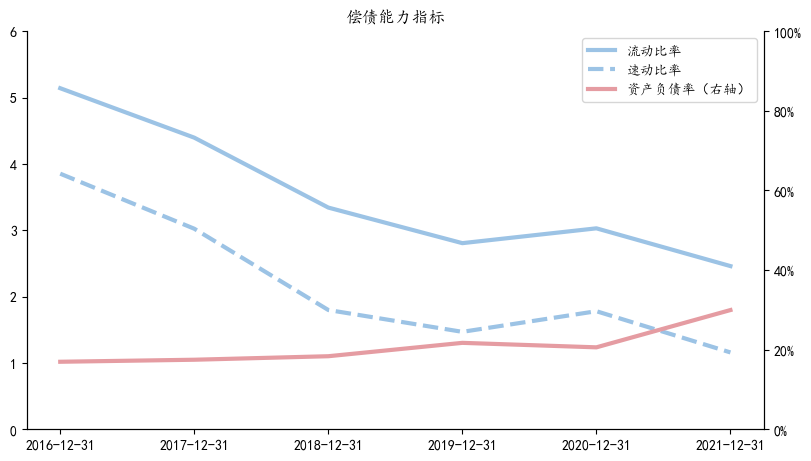

In [282]:
# 流/速动比率与资产负债率
fig, ax1 = plt.subplots(figsize=(8, 4.5), layout='constrained')
ax2 = ax1.twinx()

x1 = TheSheet.loc[:, '流动资产合计'] / TheSheet.loc[:, '流动负债合计']
x2 = (TheSheet.loc[:, '流动资产合计'] - TheSheet.loc[:, '存货净额'])/ TheSheet.loc[:, '流动负债合计']
x3 = TheSheet.loc[:, '负债合计'] / TheSheet.loc[:, '资产总计'] * 100

line11, = ax1.plot(x, x1, color=cm, linewidth=3)
line12, = ax1.plot(x, x2, color=cm, linewidth=3, linestyle='--')
line21, = ax2.plot(x, x3, color=cn2, linewidth=3)

ylim(ax1, max(x1.max(), x2.max()), 0)
ax2.set_ylim(0, 100)

ax1.spines['top'].set_color('none')
ax2.spines['top'].set_color('none')

fmt = '%.0f%%'
yticks = mtick.FormatStrFormatter(fmt)
ax2.yaxis.set_major_formatter(yticks)

plt.title("偿债能力指标")
plt.legend((line11, line12, line21), ('流动比率', '速动比率', '资产负债率（右轴）')) # Add a legend.


#### 债务的期限结构

In [283]:
# 现金和债务规模
cash = TheSheet.loc[:, '货币资金']

# 短期金融负债
sfd = TheSheet.loc[:, '短期借款'] + TheSheet.loc[:, '一年内到期的非流动负债'] + TheSheet.loc[:, '应付利息'] + TheSheet.loc[:, '应付股利'] 
# 短期经营负债
sbd = TheSheet.loc[:, '流动负债合计'] - sfd

# 长期金融负债
lfd = TheSheet.loc[:, '长期借款'] + TheSheet.loc[:, '应付债券']
# 长期经营负债
lbd = TheSheet.loc[:, '非流动负债合计'] - lfd

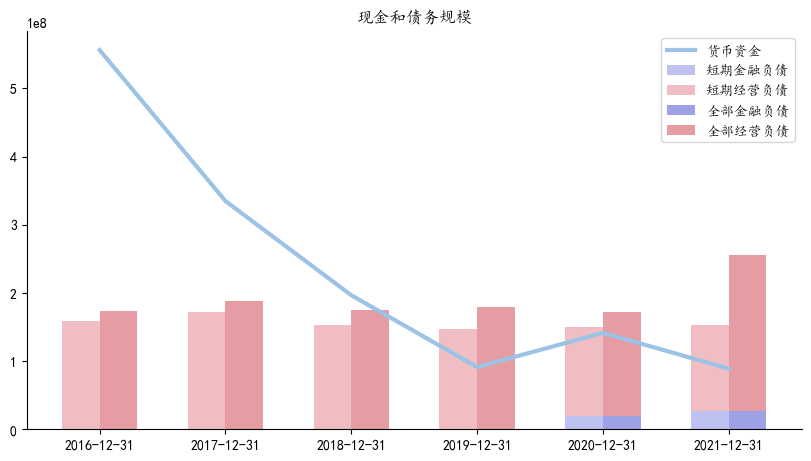

In [289]:
fig, ax = plt.subplots(figsize=(8, 4.5), layout='constrained')

x_coor = np.arange(len(x))
width = 0.3

cn1l = lightcolor(cn1)[0]
cn2l = lightcolor(cn2)[0]

ax.bar(x_coor - width/2, sfd, color=cn1l, width=width, label='短期金融负债')
ax.bar(x_coor - width/2, sbd, color=cn2l, width=width, label='短期经营负债', bottom=sfd)
ax.bar(x_coor + width/2, sfd + lfd, color=cn1, width=width, label='全部金融负债')
ax.bar(x_coor + width/2, sbd + lbd, color=cn2, width=width, label='全部经营负债', bottom=sfd + lfd)
ax.plot(x_coor, cash, color=cm, lw=3, label='货币资金')

ax.set_xticks(x_coor, x)

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

plt.title('现金和债务规模')
ax.legend()

### 3.3.    盈利能力

In [292]:
ti = TheSheet.loc[:, '营业总收入']
gp = ti - TheSheet.loc[:, '营业成本']   # 毛利润
np = TheSheet.loc[:, '净利润']


gpr = gp / ti   # 毛利率
npr = np / ti   # 净利率

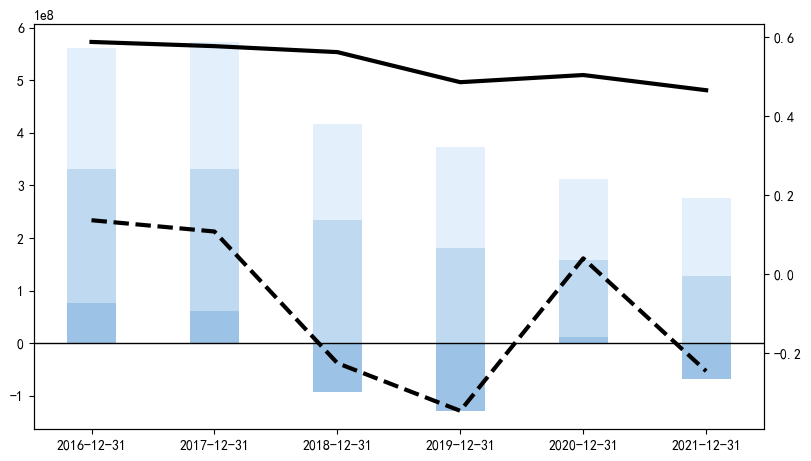

In [300]:
fig, ax1 = plt.subplots(figsize=(8, 4.5), layout='constrained')
ax2 = ax1.twinx()

b_ti = ax1.bar(x, ti, width=0.4, color=cm_l2)
b_gp = ax1.bar(x, gp, width=0.4, color=cm_l1)
b_np = ax1.bar(x, np, width=0.4, color=cm)
ax1.axhline(0, color='black', linewidth=1)

l_gpr, = ax2.plot(x, gpr, color=black, lw=3)
l_npr, = ax2.plot(x, npr, color=black, lw=3, ls='--')

### 3.4.    周转能力/营运能力

In [140]:
# 应收账款
rtr = TheSheet.loc[1:, '营业收入'] / (TheSheet.loc[:, '应收账款净额'] + TheSheet.loc[:, '应收票据净额'] + TheSheet.loc[:, '应收款项融资']).rolling(1).mean()[1:]
rtd = 360 / rtr

# 存货
itr = TheSheet.loc[1:, '营业成本'] / TheSheet.loc[:, '存货净额'].rolling(1).mean()[1:]  # 存货周转率
itd = 360 / itr # 存货周转天数

# 占用客户资金（被占用以'-'号填列）：预收 - 应收
occ = (TheSheet.loc[:, '预收款项'] + TheSheet.loc[:, '合同负债']) - (TheSheet.loc[:, '应收账款净额'] + TheSheet.loc[:, '应收票据净额'] + TheSheet.loc[:, '应收款项融资'] + TheSheet.loc[:, '合同资产'])
# 占用供应商资金（被占用以'-'号填列）：应付 - 预付
osc = (TheSheet.loc[:, '应付票据'] + TheSheet.loc[:, '应付账款']) - TheSheet.loc[:, '预付款项净额']


In [ ]:
# 周转率
fig, ax1 = plt.subplots(figsize=(8, 4.5), layout='constrained')
ax2 = ax1.twinx()
l_rtr, = ax1.plot(x[1:], rtr, color='black', linewidth=3)
l_itr, = ax2.plot(x[1:], itr, color='black', linewidth=3, linestyle='--')

ax1.spines['top'].set_color('none')
ax2.spines['top'].set_color('none')

ylim(ax1, rtr.max(), rtr.min(), 2)
ylim(ax2, itr.max(), itr.min(), 4)
# 通过最后一个参数调整y轴的精度
# 例如，若最大值是22（对应10），精度参数为2，则实际精度为 10 / 10 * 2 = 2
# 若最大值是219（对应100），精度参数为2，则实际精度为 100 / 10 * 2 = 20
# 填写的精度参数会被缩放至 (0, 10)，不填默认为10

plt.title("周转能力（周转次数）")
plt.legend((l_rtr, l_itr), ('应收账款周转率', '存货周转率（右轴）')) # Add a legend.

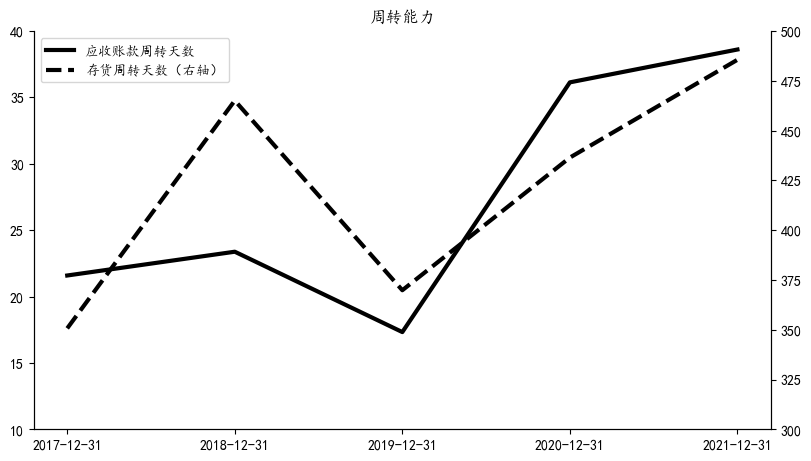

In [290]:
# 周转天数
fig, ax1 = plt.subplots(figsize=(8, 4.5), layout='constrained')
ax2 = ax1.twinx()
l_rtr, = ax1.plot(x[1:], rtd, color='black', linewidth=3)
l_itr, = ax2.plot(x[1:], itd, color='black', linewidth=3, linestyle='--')

ax1.spines['top'].set_color('none')
ax2.spines['top'].set_color('none')

ylim(ax1, rtd.max(), rtd.min(), 5)
ylim(ax2, itd.max(), itd.min(), 5)

plt.title("周转能力")
plt.legend((l_rtr, l_itr), ('应收账款周转天数', '存货周转天数（右轴）')) # Add a legend.

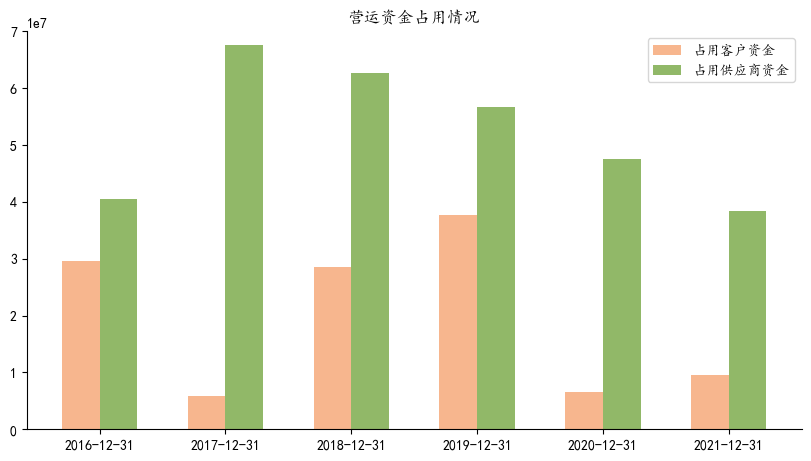

In [232]:
fig, ax = plt.subplots(figsize=(8, 4.5), layout='constrained')

x_coor = np.arange(len(x))
width = 0.3

ax.bar(x_coor - width/2, occ, color=C1, width=width, label='占用客户资金')
ax.bar(x_coor + width/2, osc, color=C2, width=width, label='占用供应商资金')

ax.set_xticks(x_coor, x)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ylim(ax, max(occ.max(), osc.max()), min(occ.min(), osc.min(), 0), 10)

plt.title('营运资金占用情况')
ax.legend()
